In [1]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)



import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

# local imports
from utils.ncfdata import NCFData
from helpers.ncf_model import NCF
from helpers import download_ml1m_dataset
from helpers.ranking_metrics import hit, ndcg
from utils.load_all_data import load_all_data
from utils.ml_to_ncf import preprocess_ml1m_to_ncf_format

In [2]:
# Configuration and hyperparameters
DATASET = 'ml-1m'

DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Model saving directory
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

# Hyperparameters
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
BATCH_SIZE = 256
EPOCHS = 20
TOP_K = 10
FACTOR_NUM = 32  # Default embedding size (will be varied in the experiment)
NUM_LAYERS = 3
NUM_NG = 4
TEST_NUM_NG = 99

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Model path for saving figures
model_path = MODEL_PATH

Using device: cpu


In [3]:
# Download and preprocess data
ratings_file = download_ml1m_dataset(DATA_DIR)
train_rating_path, test_rating_path, test_negative_path, user_num, item_num, train_mat = preprocess_ml1m_to_ncf_format(
    ratings_file, data_dir=DATA_DIR
)

✓ Dataset already exists at /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Training matrix created: 460225 interactions


In [4]:
# Load all data
train_data, test_data, user_num, item_num, train_mat = load_all_data(
    train_rating_path, test_negative_path
)

Loading training data from /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.train.rating...
✓ Loaded 460225 training pairs
  - Users: 6038
  - Items: 3533


In [5]:
# Create datasets and dataloaders
train_dataset = NCFData(
    train_data,
    item_num,
    train_mat,
    num_ng=NUM_NG,
    is_training=True
)

test_dataset = NCFData(
    test_data,
    item_num,
    train_mat,
    num_ng=0,  # No negative sampling for testing
    is_training=False
)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=TEST_NUM_NG + 1,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

In [6]:
# Evaluation function
def evaluate_metrics(model, test_loader, top_k, device='cuda'):
    """Evaluate model using HR@K and NDCG@K metrics."""
    model.eval()
    
    HR_list = []
    NDCG_list = []
    
    with torch.no_grad():
        for user, item, label in test_loader:
            # Move data to device
            if device == 'cuda' and torch.cuda.is_available():
                user = user.cuda()
                item = item.cuda()
            # else: data stays on CPU, no need to reassign device
            
            predictions = model(user, item)
            _, indices = torch.topk(predictions, top_k)
            
            # Get the actual item IDs for top-K recommendations
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            
            # Ground truth item is the first one (positive sample)
            gt_item = item[0].item()
            
            HR_list.append(hit(gt_item, recommends))
            NDCG_list.append(ndcg(gt_item, recommends))
    
    try:
        mean_HR = np.mean(HR_list)
        mean_NDCG = np.mean(NDCG_list)
    except Exception as e:
        print(f"Error calculating mean: {e}")
        mean_HR = 0
        mean_NDCG = 0
    
    return mean_HR, mean_NDCG

In [7]:
def train_and_evaluate_embedding_size(factor_num, epochs=10):
    """
    Train a model with a specific embedding size and return HR@10, and NDCG@10.
    This is a simplified version for quick evaluation.
    """
    print(f"  Training with embedding size: {factor_num}...")
    
    # Create model with specific embedding size
    test_model = NCF(
        user_num=user_num,
        item_num=item_num,
        factor_num=factor_num,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT_RATE,
        model_name='GMF',
        GMF_model=None,
        MLP_model=None
    )
    
    if device == 'cuda' and torch.cuda.is_available():
        test_model = test_model.cuda()
    
    # Setup optimizer
    test_optimizer = optim.Adam(test_model.parameters(), lr=LEARNING_RATE)
    test_loss_function = nn.BCEWithLogitsLoss()
    
    # Train for fewer epochs for speed
    best_ndcg = 0.0
    best_hr = 0.0
    
    for epoch in range(epochs):
        test_model.train()
        train_dataset.ng_sample()
        
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, (user, item, label) in enumerate(train_loader):
            if device == 'cuda' and torch.cuda.is_available():
                user = user.cuda()
                item = item.cuda()
                label = label.float().cuda()
            else:
                user = user
                item = item
                label = label.float()
            
            test_optimizer.zero_grad()
            prediction = test_model(user, item)
            loss = test_loss_function(prediction, label)
            loss.backward()
            test_optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Evaluate periodically
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            test_model.eval()
            
            HR, NDCG = evaluate_metrics(test_model, test_loader, TOP_K, device)
            # Track best metrics
            if NDCG > best_ndcg:
                best_ndcg = NDCG
            if HR > best_hr:
                best_hr = HR
    
    print(f" HR@10: {best_hr:.4f}, NDCG@10: {best_ndcg:.4f}")
    return best_hr, best_ndcg


In [8]:
# Test different embedding sizes
embedding_sizes = [8, 16, 32, 64, 128]
print(f"\nTraining models with different embedding sizes: {embedding_sizes}")
print("Note: This may take some time. Using reduced epochs for speed.")

hr_results = []
ndcg_results = []

for size in embedding_sizes:
    hr_val, ndcg_val = train_and_evaluate_embedding_size(size, epochs=10)  # Reduced epochs for speed
    hr_results.append(hr_val)
    ndcg_results.append(ndcg_val)


Training models with different embedding sizes: [8, 16, 32, 64, 128]
Note: This may take some time. Using reduced epochs for speed.
  Training with embedding size: 8...
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
 


✓ Figure 4.2 saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/figure_4.2_embedding_size.png


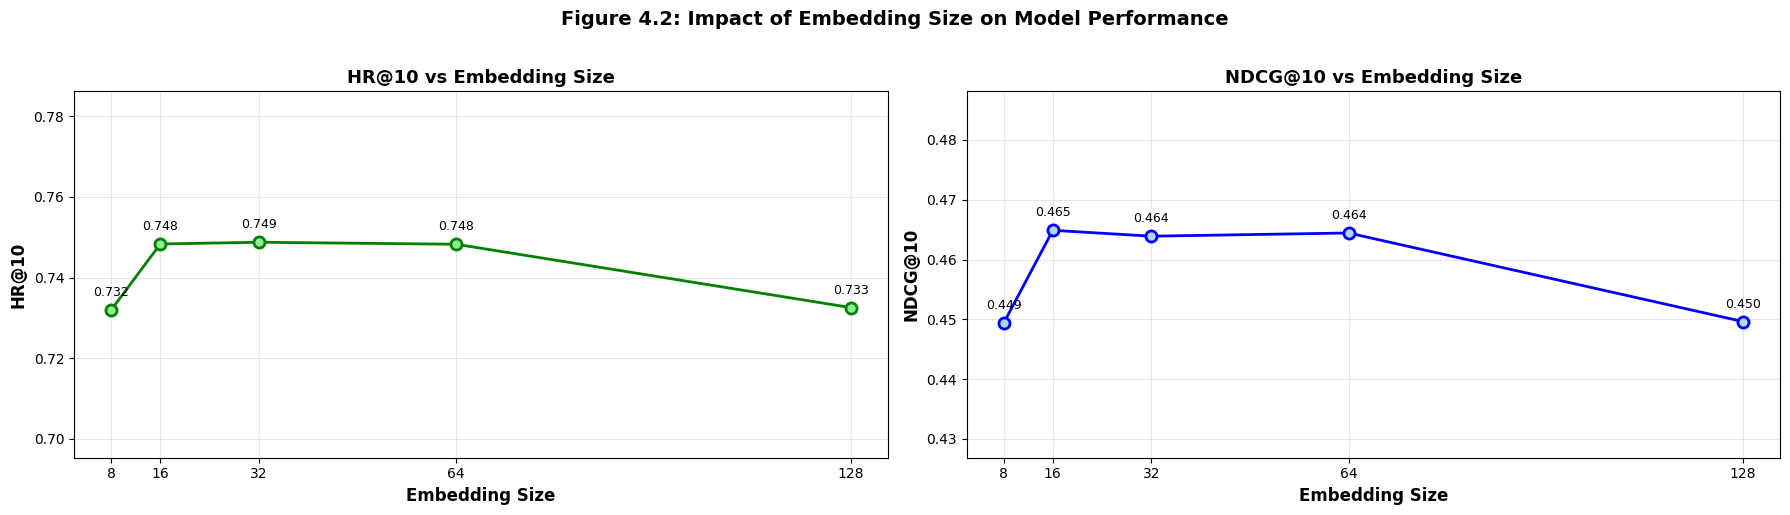


Embedding Size Impact Summary
Embedding Size  HR@10      NDCG@10   
----------------------------------------------------------------------
8               0.7319     0.4493    
16              0.7483     0.4649    
32              0.7488     0.4639    
64              0.7483     0.4644    
128             0.7326     0.4496    


In [9]:
# Create figure with subplots for all three metrics
fig_embedding, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: HR@10
axes[0].plot(embedding_sizes, hr_results, 'g-o', linewidth=2, markersize=8, 
             markerfacecolor='lightgreen', markeredgewidth=2)
axes[0].set_xlabel('Embedding Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('HR@10', fontsize=12, fontweight='bold')
axes[0].set_title('HR@10 vs Embedding Size', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(embedding_sizes)
if hr_results:
    axes[0].set_ylim([min(hr_results) * 0.95, max(hr_results) * 1.05])

# Add value labels on points
for i, (size, hr) in enumerate(zip(embedding_sizes, hr_results)):
    axes[0].annotate(f'{hr:.3f}', (size, hr), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

# Plot 2: NDCG@10
axes[1].plot(embedding_sizes, ndcg_results, 'b-o', linewidth=2, markersize=8, 
             markerfacecolor='lightblue', markeredgewidth=2)
axes[1].set_xlabel('Embedding Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('NDCG@10', fontsize=12, fontweight='bold')
axes[1].set_title('NDCG@10 vs Embedding Size', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(embedding_sizes)
if ndcg_results:
    axes[1].set_ylim([min(ndcg_results) * 0.95, max(ndcg_results) * 1.05])

# Add value labels on points
for i, (size, ndcg) in enumerate(zip(embedding_sizes, ndcg_results)):
    axes[1].annotate(f'{ndcg:.3f}', (size, ndcg), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

plt.suptitle('Figure 4.2: Impact of Embedding Size on Model Performance', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(model_path, 'figure_4.2_embedding_size.png'), dpi=300, bbox_inches='tight')
print(f"\n✓ Figure 4.2 saved to: {os.path.join(model_path, 'figure_4.2_embedding_size.png')}")
plt.show()

# Print summary
print("\n" + "=" * 70)
print("Embedding Size Impact Summary")
print("=" * 70)
print(f"{'Embedding Size':<15} {'HR@10':<10} {'NDCG@10':<10}")
print("-" * 70)
for size, hr, ndcg in zip(embedding_sizes, hr_results, ndcg_results):
    print(f"{size:<15} {hr:<10.4f} {ndcg:<10.4f}")
print("=" * 70)